# Boost and Rotate

In [1]:
import uproot as ur
import uproot_methods as urm
import numpy as np
import awkward
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils.np_utils import to_categorical   
from sklearn.metrics import roc_curve

import tools

filename = 'user.jagrundy.20736236._000001.MiniNTuple.root'

Using TensorFlow backend.


Load ntuple, get the data we need from the file

In [2]:
s_table = tools.open_file(filename, sort_by="tag")

sorting data by tag


Filters

In [3]:
# filter by realistic situation where we have 3 tags and 3 or 4 jets.
# ignore the case where there may be >4 since those are pretty rare
nb4 = (s_table.nbjets == 3) | (s_table.nbjets == 4) # 3 or 4 b-jets exist
nt3 = s_table.nbtags==3  # 3 b tags
nb4nt3 = nb4 & nt3
events = s_table[nb4nt3]
n_events = len(events)
print(n_events)

308955


Get jet locations, tag, truth

In [4]:
pt = events["resolved_lv"].pt
eta = events["resolved_lv"].eta
phi = events["resolved_lv"].phi
E = events["resolved_lv"].E
tag = events["tag"] # tag[index] = [1, 1, 1, 0, 0, ...] (len >= 4)
truth = events["truth"]

Pad arrays

In [5]:
cutoff = 10
padding_val = 0

# cut off and pad
# cutoff+1 so we can have a no-4th-jet option as last index
padded_true = pad_sequences(truth,padding='post')[:,:cutoff+1]
padded_tag = pad_sequences(tag, padding='post')[:,:cutoff+1]
padded_pt = pad_sequences(pt, padding='post', dtype='float32', value = padding_val)[:,:cutoff+1]
padded_eta = pad_sequences(eta, padding='post', dtype='float32', value = padding_val)[:,:cutoff+1]
padded_phi = pad_sequences(phi, padding='post', dtype='float32', value = padding_val)[:,:cutoff+1]
padded_E = pad_sequences(E, padding='post', dtype='float32', value = padding_val)[:,:cutoff+1]

Filter a bit more for events where we have 3 b-jets correctly tagged (plus maybe one more untagged b-jet)

In [6]:
# 1 = should have been tagged but wasn't. 0 = correctly tagged (or not tagged)
untagged = np.logical_xor(padded_true, padded_tag).astype(int)

# n_untagged[i] = number of untagged real jets in i-th event
# We want to consider only the cases where the 3 jets are correctly tagged,
# so we have take n_untagged == 1
n_untagged = np.count_nonzero(untagged, axis=1)

# where there is no true 4th jet, say there's an untagged jet in the last index
untagged[(n_untagged == 0), -1] = 1

# for now, consider only the events where one jet is not tagged
untagged = untagged[n_untagged <= 1]
# or where there are only 3 real b jets
# u for untagged<=1
pt_u = padded_pt[n_untagged <= 1]
eta_u = padded_eta[n_untagged <= 1]
phi_u = padded_phi[n_untagged <= 1]
E_u = padded_E[n_untagged <= 1]

Rotation time!

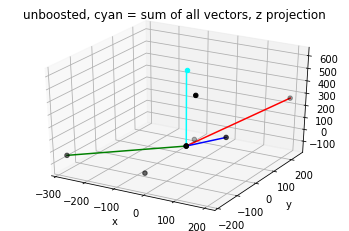

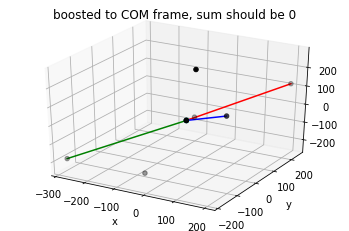

sum of eta, should be close to 0 1.6665246221291479
angle to rotate to get phi=0 for v_sum3: -1.1836887745366877


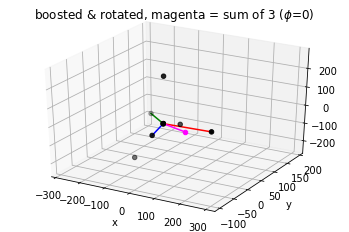

In [7]:
# an event index for which to output some info
out_index = 20

#print("event coordinates in pt, eta, phi, E")
#print(pt_u[out_index])
#print(eta_u[out_index])
#print(phi_u[out_index])
#print(E_u[out_index])

# make vectors
vectors = urm.TLorentzVectorArray.from_ptetaphie(pt_u, eta_u, phi_u, E_u)

# get sum vectors -- edited to just take z component
x_sum = np.repeat(np.zeros((len(vectors.x), 1)).reshape(-1, 1), cutoff+1, axis=1)
y_sum = np.repeat(np.zeros((len(vectors.y), 1)).reshape(-1, 1), cutoff+1, axis=1)
z_sum = np.repeat(np.sum(vectors.z, axis=1).reshape(-1, 1), cutoff+1, axis=1)
t_sum = np.repeat(np.sum(vectors.t, axis=1).reshape(-1, 1), cutoff+1, axis=1)
v_sum = urm.TLorentzVectorArray(x_sum, y_sum, z_sum, t_sum)

# plot an event
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot([0, vectors.x[out_index, 0]], [0, vectors.y[out_index, 0]], [0, vectors.z[out_index, 0]], c='red')
ax.plot([0, vectors.x[out_index, 1]], [0, vectors.y[out_index, 1]], [0, vectors.z[out_index, 1]], c='green')
ax.plot([0, vectors.x[out_index, 2]], [0, vectors.y[out_index, 2]], [0, vectors.z[out_index, 2]], c='blue')
ax.plot([0, v_sum.x[out_index, 0]], [0, v_sum.y[out_index, 0]], [0, v_sum.z[out_index, 0]], c='cyan')
ax.scatter(vectors.x[out_index], vectors.y[out_index], vectors.z[out_index], c='black')
ax.scatter(v_sum.x[out_index, 0], v_sum.y[out_index, 0], v_sum.z[out_index, 0], c='cyan')
plt.xlabel("x")
plt.ylabel("y")
plt.title("unboosted, cyan = sum of all vectors, z projection")
#plt.savefig("unboosted.png")
plt.show()

# b for boosted
vectors_b = vectors.boost(-v_sum.boostp3)
v_sum_b = v_sum.boost(-v_sum.boostp3)
# for filler data where eta = 0, we'll have NaN for eta, so replace that
eta = np.nan_to_num(vectors_b.eta, nan=0.0)
vectors_b = urm.TLorentzVectorArray.from_ptetaphie(
    vectors_b.pt, eta, vectors_b.phi, vectors_b.E)


# plot boosted version
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot([0, vectors_b.x[out_index, 0]], [0, vectors_b.y[out_index, 0]], [0, vectors_b.z[out_index, 0]], c='red')
ax.plot([0, vectors_b.x[out_index, 1]], [0, vectors_b.y[out_index, 1]], [0, vectors_b.z[out_index, 1]], c='green')
ax.plot([0, vectors_b.x[out_index, 2]], [0, vectors_b.y[out_index, 2]], [0, vectors_b.z[out_index, 2]], c='blue')
ax.plot([0, v_sum_b.x[out_index, 0]], [0, v_sum_b.y[out_index, 0]], [0, v_sum_b.z[out_index, 0]], c='cyan')
# comment next line to see the cyan dot, which should be at 0
ax.scatter(vectors_b.x[out_index], vectors_b.y[out_index], vectors_b.z[out_index], c='black')
ax.scatter(v_sum_b.x[out_index, 0], v_sum_b.y[out_index, 0], v_sum_b.z[out_index, 0], c='cyan')
plt.xlabel("x")
plt.ylabel("y")
plt.title("boosted to COM frame, sum should be 0")
#plt.savefig("boosted.png")
plt.show()

print("sum of eta, should be close to 0", np.sum(vectors_b.eta[out_index]))


# now rotate the system based on the first 3 jets
# get sum of the first 3, similarly to before
x_sum3 = np.repeat(np.sum(vectors_b.x[:,:3], axis=1).reshape(-1, 1), cutoff+1, axis=1)
y_sum3 = np.repeat(np.sum(vectors_b.y[:,:3], axis=1).reshape(-1, 1), cutoff+1, axis=1)
z_sum3 = np.repeat(np.sum(vectors_b.z[:,:3], axis=1).reshape(-1, 1), cutoff+1, axis=1)
t_sum3 = np.repeat(np.sum(vectors_b.t[:,:3], axis=1).reshape(-1, 1), cutoff+1, axis=1)
v_sum3 = urm.TLorentzVectorArray(x_sum3, y_sum3, z_sum3, t_sum3)


# rotate about z so that phi=0 for v_sum3
print("angle to rotate to get phi=0 for v_sum3:", -v_sum3.phi[out_index,0])
vectors_r = vectors_b.rotatez(-v_sum3.phi)
v_sum3 = v_sum3.rotatez(-v_sum3.phi)

# plot again!
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot([0, vectors_r.x[out_index, 0]], [0, vectors_r.y[out_index, 0]], [0, vectors_r.z[out_index, 0]], c='red')
ax.plot([0, vectors_r.x[out_index, 1]], [0, vectors_r.y[out_index, 1]], [0, vectors_r.z[out_index, 1]], c='green')
ax.plot([0, vectors_r.x[out_index, 2]], [0, vectors_r.y[out_index, 2]], [0, vectors_r.z[out_index, 2]], c='blue')
ax.plot([0, v_sum3.x[out_index, 0]], [0, v_sum3.y[out_index, 0]], [0, v_sum3.z[out_index, 0]], c='magenta')
ax.scatter(vectors_r.x[out_index], vectors_r.y[out_index], vectors_r.z[out_index], c='black')
ax.scatter(v_sum3.x[out_index, 0], v_sum3.y[out_index, 0], v_sum3.z[out_index, 0], c='magenta')
plt.xlabel("x")
plt.ylabel("y")
plt.title("boosted & rotated, magenta = sum of 3 ($\phi$=0)")
#plt.savefig("rotated.png")
plt.show()

# and again replace filler etas with 0
eta = np.nan_to_num(vectors_r.eta, nan=0.0)
vectors_r = urm.TLorentzVectorArray.from_ptetaphie(
    vectors_r.pt, eta, vectors_r.phi, vectors_r.E)


In [8]:
vectors_final = vectors_r

In [9]:
# snip off the 3 first jets since they're already tagged correctly
# (given our filtering procedure above)
untagged = untagged[:, 3:]
pt = vectors_final.pt[:, 3:]
eta = vectors_final.eta[:, 3:]
phi = vectors_final.phi[:, 3:]

# where does the untagged jet occur?
# 7 = no 4th jet, 0-6 means set that index's jet = 4th
missed_jet_index = np.where(untagged==1)[1]

In [10]:
# scale data to be keras-friendly
scaler_pt = StandardScaler()
scaler_eta = StandardScaler()
scaler_phi = StandardScaler()

# s for scaled
s_pt = scaler_pt.fit_transform(pt)
s_eta = scaler_eta.fit_transform(eta)
s_phi = scaler_phi.fit_transform(phi)

# stack pt, eta, phi for input into model
s_in = np.column_stack((s_pt, s_eta, s_phi))
print(pt[out_index])
print(s_pt[out_index])
print(eta[out_index])
print(s_eta[out_index])
print(phi[out_index])
print(s_phi[out_index])
print(untagged[out_index])

[133.17671174  47.64471193  25.79642788   0.           0.
   0.           0.           0.        ]
[-0.17848445 -0.16385933  0.0521018  -0.51060995 -0.32373524 -0.18993422
 -0.10656462 -0.05686401]
[-1.33472523 -0.24625006  3.04222555  0.          0.          0.
  0.          0.        ]
[-1.06995589e+00 -1.73155447e-01  2.32118011e+00 -3.16611330e-03
 -2.33934356e-03  9.33161298e-04 -2.70675064e-03 -2.13171447e-04]
[ 3.05204767  0.46196459 -0.64055812  0.          0.          0.
  0.          0.        ]
[ 1.14329847e+00  2.53187418e-01 -4.56150235e-01  3.13892798e-03
  3.58067637e-04 -2.94064542e-03  1.15820923e-03 -1.28178638e-03]
[0 0 0 0 0 0 0 1]


Split data into training, validation, and testing subsets

In [11]:
# split missed_jet into training, validation, testing subsets
train, val, test = tools.splitTVT(untagged, trainfrac=0.7, testfrac=0.2)

To do: experiment with different kinds of networks

In [12]:
model = Sequential()
model.add(Dense(24, input_dim=24, kernel_initializer='normal', activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(24, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(15, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(8, kernel_initializer='normal', activation='softmax'))
# compile model
optimizer = Adam(lr=5e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [13]:
import time
before = time.time()
history = model.fit(s_in[train], untagged[train], validation_data=(s_in[val], untagged[val]), epochs = 200, batch_size = 200, verbose = 1)

timedelta = time.time() - before
print(timedelta)


59/200
212748/212748 [==============================] - 2s 8us/step - loss: 1.0315 - acc: 0.5419 - val_loss: 1.0299 - val_acc: 0.5428
Epoch 60/200
212748/212748 [==============================] - 2s 8us/step - loss: 1.0310 - acc: 0.5417 - val_loss: 1.0296 - val_acc: 0.5424
Epoch 61/200
212748/212748 [==============================] - 2s 8us/step - loss: 1.0305 - acc: 0.5418 - val_loss: 1.0292 - val_acc: 0.5418
Epoch 62/200
212748/212748 [==============================] - 2s 8us/step - loss: 1.0301 - acc: 0.5416 - val_loss: 1.0288 - val_acc: 0.5445
Epoch 63/200
212748/212748 [==============================] - 2s 8us/step - loss: 1.0296 - acc: 0.5421 - val_loss: 1.0280 - val_acc: 0.5443
Epoch 64/200
212748/212748 [==============================] - 2s 8us/step - loss: 1.0292 - acc: 0.5418 - val_loss: 1.0275 - val_acc: 0.5431
Epoch 65/200
212748/212748 [==============================] - 2s 8us/step - loss: 1.0287 - acc: 0.5420 - val_loss: 1.0271 - val_acc: 0.5439
Epoch 66/200
212748/212748

<Figure size 432x288 with 0 Axes>

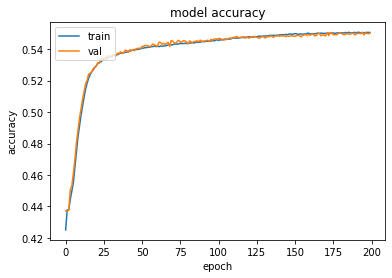

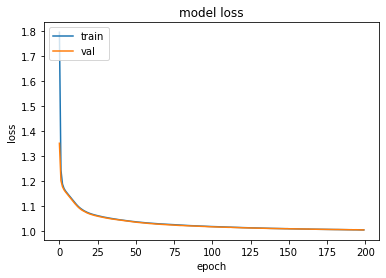

In [14]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('Plots/accuracy_{}.pdf'.format(layer_name))
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('Plots/loss_{}.pdf'.format(layer_name))
plt.show()

In [15]:
nn_score = model.predict(s_in)

In [16]:
test_nn_score = nn_score[test]

# sort nn_score highest to lowest
indices = test_nn_score.argsort()

# prepare for roc curve plot
best_index_asc = test_nn_score.argsort(axis=1)
best_index = best_index_asc[:,::-1]
test_mj = untagged[test]
s_test_mj = test_mj[np.arange(test_mj.shape[0])[:,None], best_index]
s_test_score = test_nn_score[np.arange(test_nn_score.shape[0])[:,None], best_index]
max_true = to_categorical(s_test_mj[:,0], num_classes = 2)
max_true = s_test_mj[:,0]
max_val = s_test_score[:,0]
fpr, tpr, thresholds = roc_curve(max_true, max_val, pos_label=1)

<Figure size 432x288 with 0 Axes>

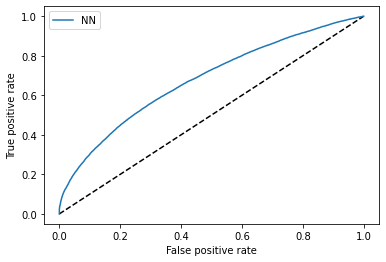

In [17]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='NN')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
# plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
# plt.savefig('Plots/roc_combine2_cnn.pdf')
plt.show()

A sample event

In [18]:
n_test = len(test) 

# get truth and tag arrays back
test_truth = np.array([[1, 1, 1] + list(t) for t in untagged[test]])
# all the tags were just 111000000 by construction
test_tag = np.array([[1, 1, 1] + [0]*len(t) for t in untagged[test]])

# selection_index[i] is between 0 and 7
# these correspond to picking jet 4 --> 10 or no jet ("jet 11")
selection_index = np.argmax(nn_score[test], axis=1)

# put this in a better format
selection_index += 3
selections = np.zeros_like(test_tag, dtype=int)
for i, s in enumerate(selection_index):
    selections[i][s] = 1

# then chop off the last index so selection = [0,...,0] for no selection
test_truth = test_truth[:, :-1]
test_tag = test_tag[:, :-1]
selections = selections[:, :-1]

In [19]:

tools.evaluate_model(test_truth, test_tag, selections)


100%|██████████| 60785/60785 [00:00<00:00, 115629.91it/s]

    Total number of events: 60785
    Minus events ignored: 0, (0.00%)

    4th b-jet really exists:
        Correct 4th jet picked:         42.86%, 14580
        Incorrect 4th jet picked:       14.99%, 5099
        Event incorrectly ignored:      42.15%, 14340

    No 4th b-jet really exists:
        Correctly ignored event:        70.81%, 18953
        Incorrectly picked a 4th jet:   29.19%, 7813

    Or formatted in table form:
                    ____________________
                   |Truth-Matching      |
                   |____________________|
                   |4th exists  |No 4th |
     ______________|____________|_______|
    |4th |4th found|corr. 042.9%| 029.2%|
    |Jet |         |inco. 015.0%|       |
    |Reco|_________|____________|_______|
    |    |no 4th   |      042.2%| 070.8%|
    |____|_________|____________|_______|

    (columns add to 100% each)
    

